<a href="https://colab.research.google.com/github/VoXuanLanh/BT_fuzzy_Logic/blob/main/Vietnamese_Banknotes_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q gdown

In [2]:
import gdown

file_id = "1Aad4rgbiLWPKzoTJHhnOn-63bJHVIVA7"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="/content/vietnamese_money.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Aad4rgbiLWPKzoTJHhnOn-63bJHVIVA7
From (redirected): https://drive.google.com/uc?id=1Aad4rgbiLWPKzoTJHhnOn-63bJHVIVA7&confirm=t&uuid=7c2e9d52-c7d3-4e1e-8195-f67aad705b3f
To: /content/vietnamese_money.zip
100%|██████████| 314M/314M [00:05<00:00, 60.5MB/s]


'/content/vietnamese_money.zip'

In [3]:
!unzip -q /content/vietnamese_money.zip -d /content/vn_money_data
print(" Giải nén xong")

 Giải nén xong


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

img_size = 64
classes = ["1000", "2000", "5000", "10000", "20000", "50000", "100000", "200000", "500000"]
base_dir = "/content/vn_money_data"

def load_data_from_csv(csv_path, folder):
    df = pd.read_csv(csv_path)
    X, y = [], []

    for _, row in df.iterrows():
        label = None
        for i, class_name in enumerate(classes):
            if row[class_name] == 1:
                label = class_name
                break

        if label is None:
            continue

        img_path = os.path.join(base_dir, folder, row['filename'])
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
        y.append(label)
    if not X or not y:
        print("Error: No data loaded. Check your CSV and image paths.")
        return None, None

    return np.array(X), np.array(y)

X_train, y_train = load_data_from_csv(f"{base_dir}/train/_classes.csv", "train")
X_valid, y_valid = load_data_from_csv(f"{base_dir}/valid/_classes.csv", "valid")
data = np.array(X_train)
labels = np.array(y_train)

img_flatten=data.reshape(len(data),64,64,3)



X_train = X_train.reshape(X_train.shape[0], 64*64*3)
X_train = X_train.astype('float32')/255
X_valid = X_valid.reshape(X_valid.shape[0], 64*64*3)
X_valid = X_valid.astype('float32')/255

print(X_train.shape)
print(len(y_train))
print(X_train.ndim)
print(X_valid.shape)
print(len(y_valid))
print(X_valid.ndim)


(4605, 12288)
4605
2
(439, 12288)
439
2


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)


In [6]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train_encoded)

y_valid_encoded = encoder.transform(y_valid)
y_valid_categorical = to_categorical(y_valid_encoded)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(64*64*3,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = model.fit(X_train, y_train_categorical,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_valid, y_valid_categorical))

Epoch 1/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.3130 - loss: 9.7298 - val_accuracy: 0.5535 - val_loss: 1.3954
Epoch 2/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - accuracy: 0.3696 - loss: 2.9875 - val_accuracy: 0.5148 - val_loss: 1.4399
Epoch 3/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - accuracy: 0.4383 - loss: 1.7794 - val_accuracy: 0.5535 - val_loss: 1.3298
Epoch 4/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.4731 - loss: 1.5522 - val_accuracy: 0.5923 - val_loss: 1.2026
Epoch 5/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.5171 - loss: 1.4746 - val_accuracy: 0.6333 - val_loss: 1.1376
Epoch 6/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.5261 - loss: 1.3932 - val_accuracy: 0.5877 - val_loss: 1.1065
Epoch 7/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.5471 - loss: 1.2676 - val_accuracy: 0.6469 - val_loss: 1.0409
Epoch 8/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.5741 -

In [9]:
import pandas as pd

# Đọc file CSV chứa nhãn thật
df = pd.read_csv("/content/vn_money_data/test/_classes.csv")
df.head()


,filename,1000,10000,100000,2000,20000,200000,5000,50000,500000
0,IMG_9902_jpeg.rf.79df31bba26da110cba007368e51d...,0,0,0,0,1,1,0,0,1
1,4ed7b130-2a02-40b0-a07c-eaecef8eaabd_jpg.rf.96...,0,0,0,0,0,0,0,0,1
2,1295_jpg.rf.9f3950e24237177e820211a193ab3067.jpg,0,0,1,0,0,0,0,1,1
3,5212752_jpg.rf.6897d4d49b68ba13ea6f3c72eab872b...,1,0,0,1,0,0,1,0,0
4,frame0-00-29-63-4-_jpg.rf.a56d6630a3734a393833...,1,0,0,0,0,0,0,0,0


In [10]:
# Tìm dòng tương ứng với ảnh đang kiểm tra
filename = "1295_jpg.rf.9f3950e24237177e820211a193ab3067.jpg"
row = df[df['filename'] == filename]

# In ra nhãn thật
true_label = row.drop(columns=['filename']).idxmax(axis=1).values[0]
print("Mệnh giá:", true_label)

Mệnh giá: 100000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mệnh giá dự đoán: 1000 VND - Độ chính xác: 26.54%


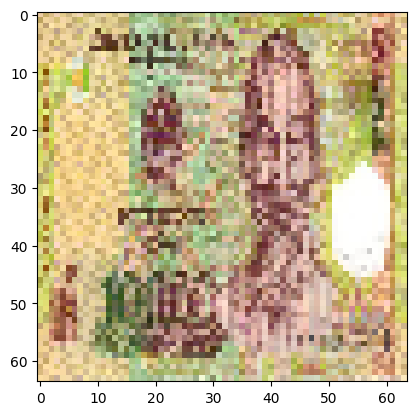

In [15]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
# Load ảnh, resize giống kích thước ảnh train
img = load_img('/content/10vnd.jpg', target_size=(64, 64))
plt.imshow(img)

# Chuyển đổi ảnh thành mảng numpy
img_array = img_to_array(img) / 255 # Chuẩn hóa pixel về [0,1]
img_flatten=img_array.reshape(1,64*64*3)

# Dự đoán
pred = model.predict(img_flatten)
predicted_label = classes[np.argmax(pred)]
confidence = np.max(pred)

print(f"Mệnh giá dự đoán: {predicted_label} VND - Độ chính xác: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Mệnh giá dự đoán: 10000 VND - Độ chính xác: 100.00%


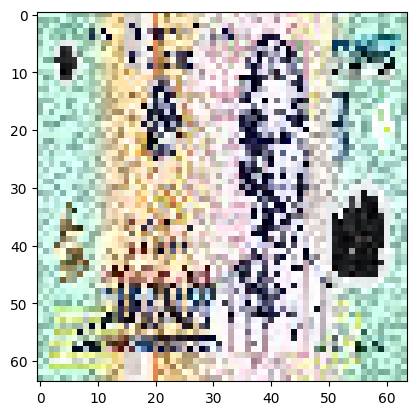

In [16]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
# Load ảnh, resize giống kích thước ảnh train
img = load_img('/content/500vnd.jpg', target_size=(64, 64))
plt.imshow(img)

# Chuyển đổi ảnh thành mảng numpy
img_array = img_to_array(img) / 255 # Chuẩn hóa pixel về [0,1]
img_flatten=img_array.reshape(1,64*64*3)

# Dự đoán
pred = model.predict(img_flatten)
predicted_label = classes[np.argmax(pred)]
confidence = np.max(pred)

print(f"Mệnh giá dự đoán: {predicted_label} VND - Độ chính xác: {confidence*100:.2f}%")

In [17]:
model.save("lan2.keras")